In [1]:
from swat import *
import sys, os

## Training Data name
data_name = "S1_5143_T_SR1+DAM_OSP+SOP_01_01"
modelname = data_name+'_VGG16'
## Model Dir
model_dir = '/home/sasdemo01/models/AVI/S1/'

## Result Saved Dir
result_out_dir = '/home/sasdemo01/result/AVI/S1/Testing/0212/'

## Testing Folder (Folder)
path = "/home/sasdemo01/data/AVI/S1/Testing_Convert/0212/"
filelist = os.listdir(path)
### If only one folder
#filelist =['19BM2025-01-00']

gpus = {4,5,6,7}
size= 128

## Save checklist or not
save_check = True

filelist

['19BM2025-01-00',
 '19BM2025-04-00',
 '19BM2025-05-00',
 '19BM2043-08-00',
 '19BM2044-02-00',
 '19BM2044-06-00',
 '19BM2059-06-00',
 '19BM2059-07-00',
 '19BR2031-04-00',
 '19BR2031-05-00',
 '19BC2038-04-00']

In [2]:
fp = open(model_dir+"/"+modelname+"_info.txt","r")
threshold = float(fp.readline())
channel_mean = [float(fp.readline()),float(fp.readline()),float(fp.readline())]

In [3]:

os.environ['CAS_CLIENT_SSL_CA_LIST']='/opt/sas/viya/config/etc/SASSecurityCertificateFramework/cacerts/vault-ca.crt'
import pandas as pd
import subprocess

from dlpy.applications import *
from dlpy.images import ImageTable
from dlpy.splitting import two_way_split, three_way_split
from dlpy.applications import *
from dlpy.model import *

%matplotlib inline
from matplotlib import pyplot

s = CAS("sas-instance", 5570, "sasdemo01", "demopw")

s.builtins.actionSetInfo()
s.loadactionset('table')
s.loadactionset('image')
s.loadactionset('deepLearn')


NOTE: Added action set 'table'.
NOTE: Added action set 'image'.
NOTE: Added action set 'deepLearn'.


[actionset]

 'deepLearn'

+ Elapsed: 0.0322s, user: 0.0121s, sys: 0.02s, mem: 0.214mb

In [4]:
model = VGG16(s, model_table=modelname, 
              n_classes=2, 
              n_channels=1,             
              width=size, 
              height=size, 
              scale=1, 
              random_flip='HV', 
             offsets=channel_mean
             )


model.load_weights(path=model_dir + modelname+'_weights.sashdat')

NOTE: Input layer added.
NOTE: Convolution layer added.
NOTE: Convolution layer added.
NOTE: Pooling layer added.
NOTE: Convolution layer added.
NOTE: Convolution layer added.
NOTE: Pooling layer added.
NOTE: Convolution layer added.
NOTE: Convolution layer added.
NOTE: Convolution layer added.
NOTE: Pooling layer added.
NOTE: Convolution layer added.
NOTE: Convolution layer added.
NOTE: Convolution layer added.
NOTE: Pooling layer added.
NOTE: Convolution layer added.
NOTE: Convolution layer added.
NOTE: Convolution layer added.
NOTE: Pooling layer added.
NOTE: Fully-connected layer added.
NOTE: Fully-connected layer added.
NOTE: Output layer added.
NOTE: Model compiled successfully.
NOTE: Model weights attached successfully!
NOTE: S1_5143_T_SR1+DAM_OSP+SOP_01_01_VGG16_weights_attr.sashdat is used as weigths attribute.
NOTE: Model attributes attached successfully!


In [ ]:
first=True
for test_file in filelist:
    if not os.path.exists(result_out_dir+test_file):
        os.makedirs(result_out_dir+test_file)
    test_data_dir = path + test_file
    s.image.loadImages(casout={'name':'test','blocksize':64,'replace':True},
                       path=test_data_dir, recurse = 'True', labellevels=1)

    s.image.processimages(casout={'name':'test_resize','replace':True},
                          imagefunctions=
                          [
                           {
                           'functionoptions':{'functiontype':'resize','h':size,'w':size}
                           }
                          ],                      
                         imagetable=dict(name='test'))
    TestTbl=s.CASTable('test_resize')
    pred_table = model.predict(data=TestTbl, use_best_weights=True, gpu = dict(useGPU=True,device=gpus))["OutputCasTables"]
    pred_table = s.CASTable(pred_table["Name"].item())
    pred_out = pred_table[["_label_", "_path_", "P__label_OK", "I__label_"]]
    pred_out = pd.DataFrame(pred_out.to_frame())
    pred_out.columns = ["Flag", "Filename", "OK_Prob.", "P_label"]

    ## Plot NG, OK
    pyplot.figure(figsize=(12,4))
    pyplot.xlabel('OK_Prob. Scored by DL Model')
    pyplot.ylabel('Image Quantity')
    pyplot.hist(pred_out[pred_out['Flag']=='OK']['OK_Prob.'], bins=50, alpha=0.5, label='OK', color='lime')#''lime')
    pyplot.hist(pred_out[pred_out['Flag']=='NG']['OK_Prob.'], bins=50, alpha=0.5, label='NG',color='hotpink')#'hotpink')
    pyplot.legend(loc='upper center')
    pyplot.savefig(result_out_dir+test_file+'/OK_NG_Prob.png')

    ## Write txt
    ori_cm=pd.crosstab(pred_out.Flag,pred_out.P_label,margins=True)
    with open(result_out_dir+test_file+'/result.txt','w') as f:
        f.write("For data: %s\n"%test_data_dir) 
        f.write("when threshold = 0.5:\n")
        f.write(str(ori_cm.values))
        f.write("\n")
        f.write("Accuracy = %f percent\n"%round((ori_cm.NG[0]+ori_cm.OK[1])/ori_cm.All[2]*100,2))
        f.write("Escape Rate = %f ppm\n"%round(ori_cm.OK[0]/ori_cm.All[2]*1000000,2))
        f.write("Overkill = %f percent\n"%round(ori_cm.NG[1]/ori_cm.All[2]*100,2))
        f.write("-----------------------------------------------------------------\n")
        f.write("===== Threshold: %d =====\n"%threshold)
        pred_out['P_label_New_TH'] = pred_out['OK_Prob.'].apply(lambda x: 'NG' if x <= threshold else 'OK')

        cm=pd.crosstab(pred_out.Flag, pred_out.P_label_New_TH, margins=True)
        f.write("For data: %s\n"%test_data_dir) 
        f.write("when threshold = %d \n"%threshold)
        f.write(str(cm.values))
        f.write("\n")
        if(cm.shape==ori_cm.shape):
            f.write("Accuracy = %f percent\n"%round((cm.NG[0]+cm.OK[1])/cm.All[2]*100,2))
            f.write("Escape Rate = %f ppm\n"%round(cm.OK[0]/cm.All[2]*1000000,2))
            f.write("Overkill = %f percent\n"%round(cm.NG[1]/cm.All[2]*100,2))
        else:
            f.write("Accuracy = %f percent\n"%round((cm.NG[0])/cm.All[2]*100,2))
            f.write("Escape Rate =0.00 ppm\n")
            f.write("Overkill = %f percent\n"%round(cm.NG[1]/cm.All[2]*100,2))
        #pred_out.columns = ["Flag", "Filename", "OK_Prob.", "P_label"]
        if(first):
            final_pred_out = pred_out.copy()
            first=False
        else:
            final_pred_out = final_pred_out.append(pred_out)
        pred_out.to_csv(result_out_dir+test_file+'/compare.csv')
        final_pred=final_pred.append(pred_out,ignore_index=True)
        f.write("=====================================================================")  


NOTE: Loaded 3670 images from /home/sasdemo01/data/AVI/S1/Testing_Convert/0212/19BM2025-01-00 into Cloud Analytic Services table test.
NOTE: Table TEST contains compressed images.
NOTE: 3670 out of 3670 images were processed successfully and saved as compressed images to the Cloud Analytic Services table test_resize.
NOTE: Using sas-instance.nchc.org.tw: 4 out of 8 available GPU devices.


/home/sasdemo01/anaconda3/envs/py3_6_6/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: `item` has been deprecated and will be removed in a future version
/home/sasdemo01/anaconda3/envs/py3_6_6/lib/python3.6/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


NOTE: Loaded 8268 images from /home/sasdemo01/data/AVI/S1/Testing_Convert/0212/19BM2025-04-00 into Cloud Analytic Services table test.
NOTE: Table TEST contains compressed images.
NOTE: 8268 out of 8268 images were processed successfully and saved as compressed images to the Cloud Analytic Services table test_resize.
NOTE: Using sas-instance.nchc.org.tw: 4 out of 8 available GPU devices.
NOTE: Loaded 4639 images from /home/sasdemo01/data/AVI/S1/Testing_Convert/0212/19BM2025-05-00 into Cloud Analytic Services table test.
NOTE: Table TEST contains compressed images.
NOTE: 4639 out of 4639 images were processed successfully and saved as compressed images to the Cloud Analytic Services table test_resize.
NOTE: Using sas-instance.nchc.org.tw: 4 out of 8 available GPU devices.
NOTE: Loaded 4676 images from /home/sasdemo01/data/AVI/S1/Testing_Convert/0212/19BM2043-08-00 into Cloud Analytic Services table test.
NOTE: Table TEST contains compressed images.
NOTE: 4676 out of 4676 images were pro

NOTE: Loaded 6718 images from /home/sasdemo01/data/AVI/S1/Testing_Convert/0212/19BM2059-06-00 into Cloud Analytic Services table test.
NOTE: Table TEST contains compressed images.
NOTE: 6718 out of 6718 images were processed successfully and saved as compressed images to the Cloud Analytic Services table test_resize.
NOTE: Using sas-instance.nchc.org.tw: 4 out of 8 available GPU devices.
NOTE: Loaded 3792 images from /home/sasdemo01/data/AVI/S1/Testing_Convert/0212/19BM2059-07-00 into Cloud Analytic Services table test.
NOTE: Table TEST contains compressed images.
NOTE: 3792 out of 3792 images were processed successfully and saved as compressed images to the Cloud Analytic Services table test_resize.


## Visulization

/home/sasdemo01/anaconda3/envs/py3_6_6/lib/python3.6/site-packages/swat/cas/table.py:9147: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  return self._fetch().ix[:, 0].tolist()


NOTE: Cloud Analytic Services dropped table TEMP_PLOT from caslib CASUSER(sasdemo01).


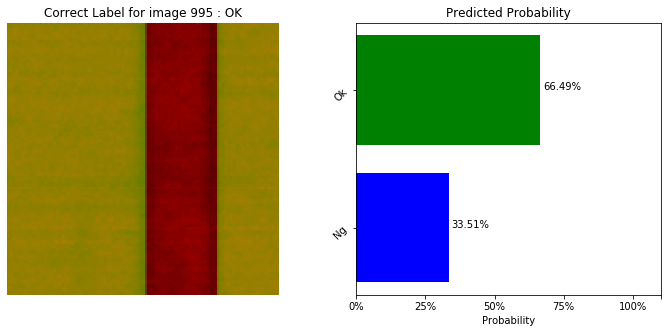

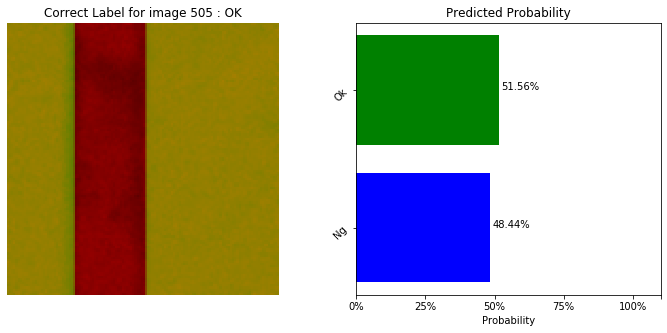

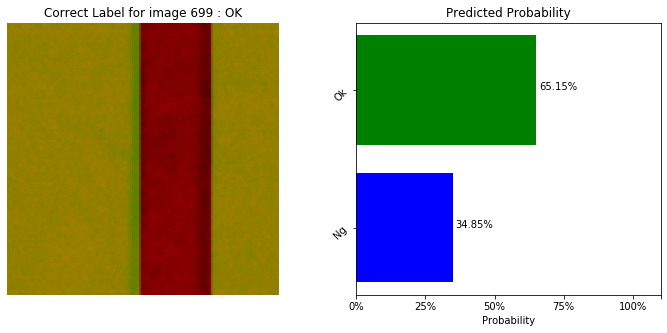

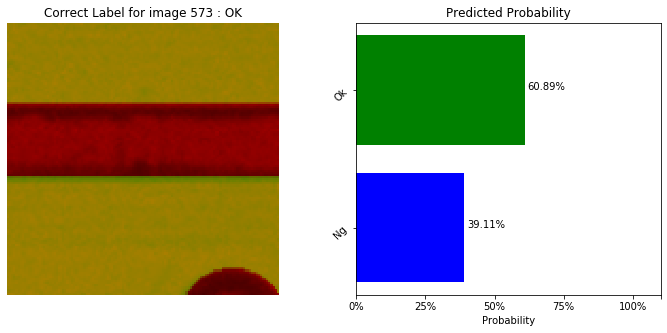

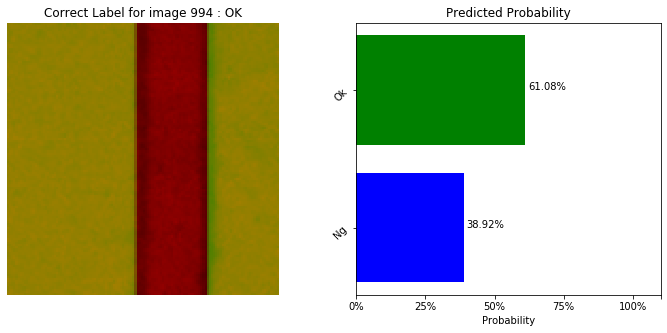

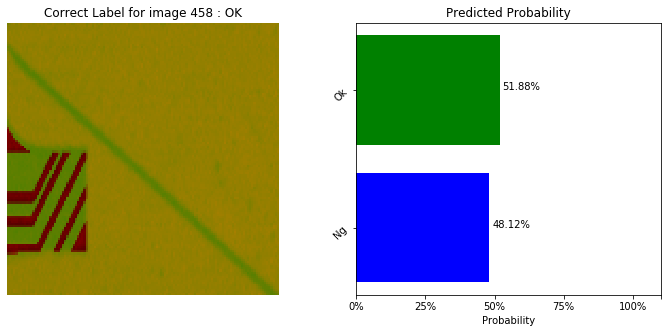

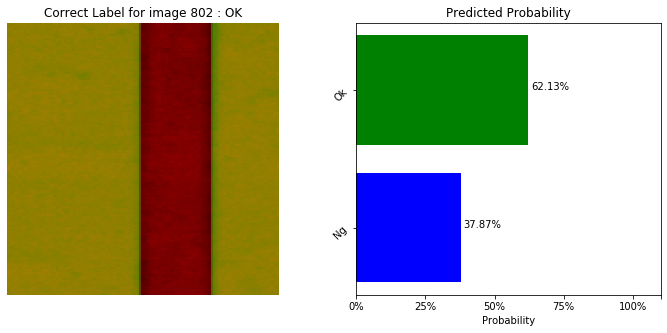

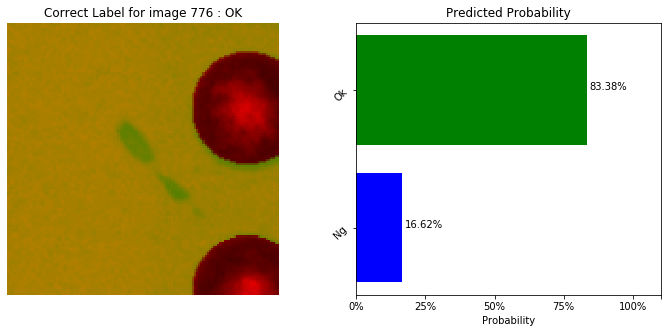

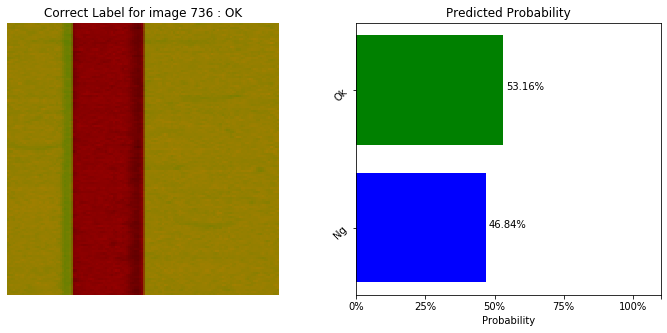

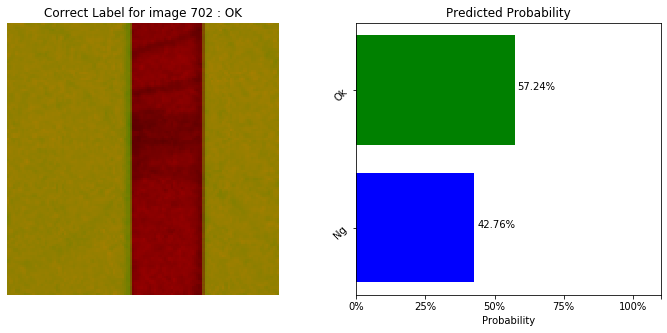

In [19]:
model.plot_evaluate_res(img_type='C', label_class='OK',randomize=True, n_images=10)

NOTE: Cloud Analytic Services dropped table TEMP_PLOT from caslib CASUSER(sasdemo01).


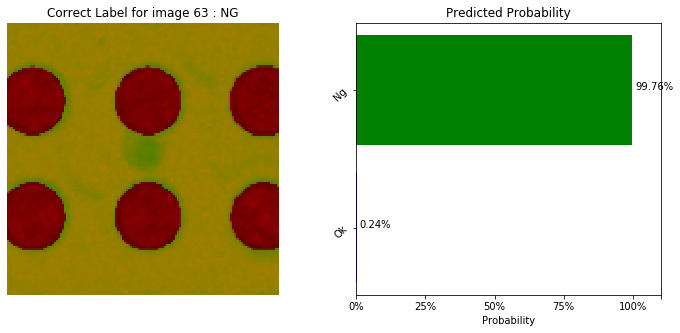

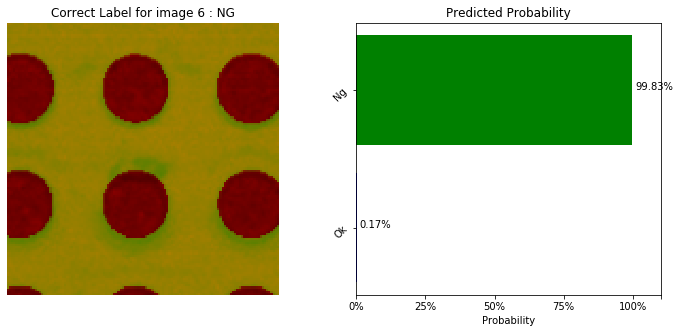

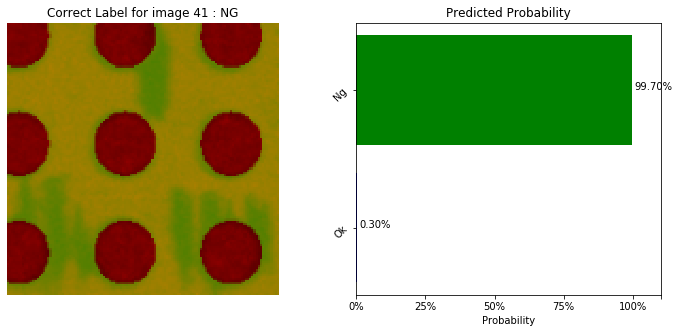

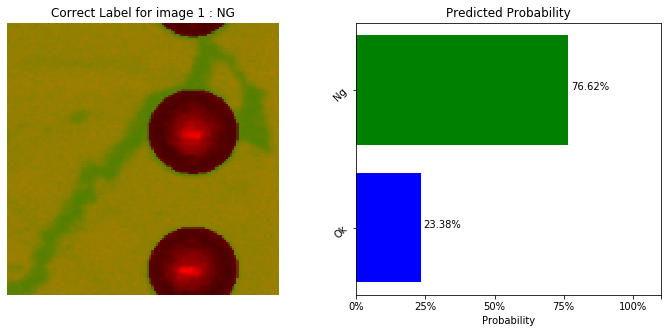

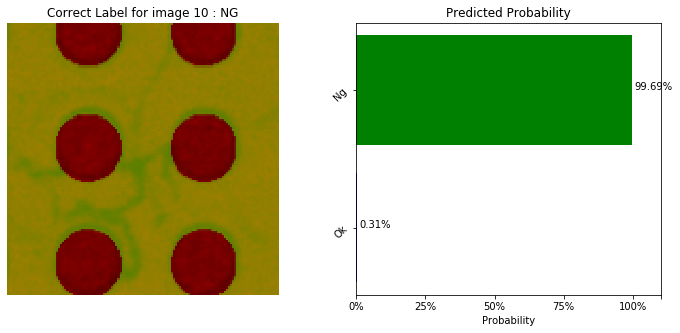

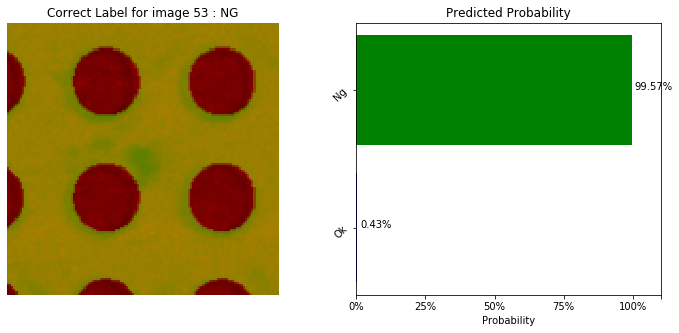

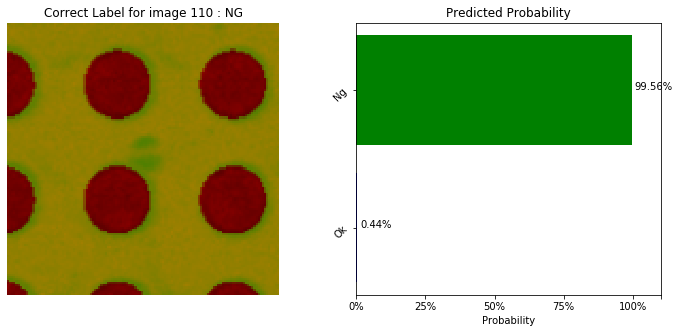

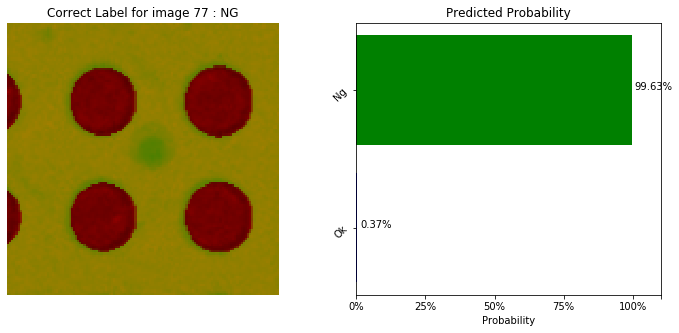

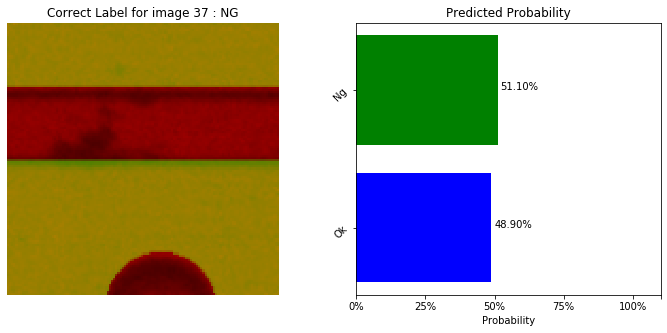

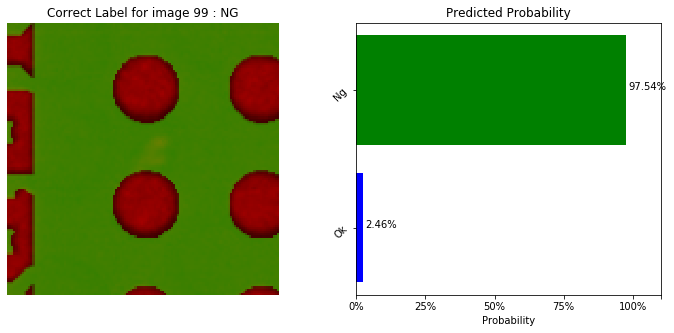

In [20]:
model.plot_evaluate_res(img_type='C', label_class='NG',randomize=True, n_images=10)

NOTE: Cloud Analytic Services dropped table TEMP_PLOT from caslib CASUSER(sasdemo01).


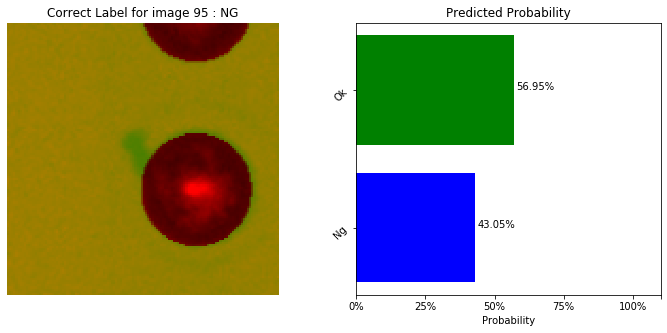

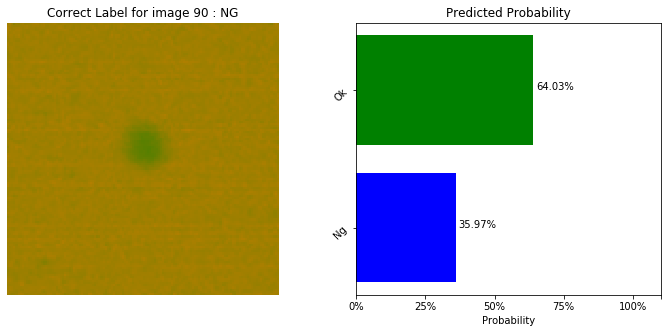

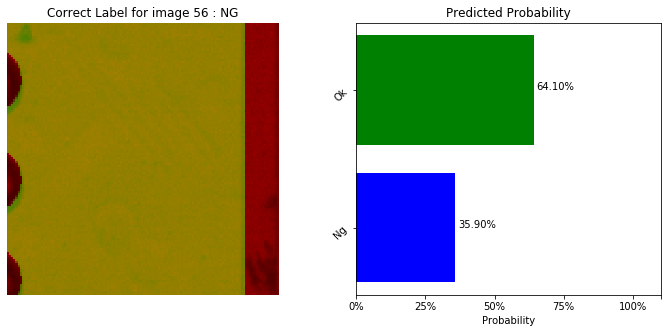

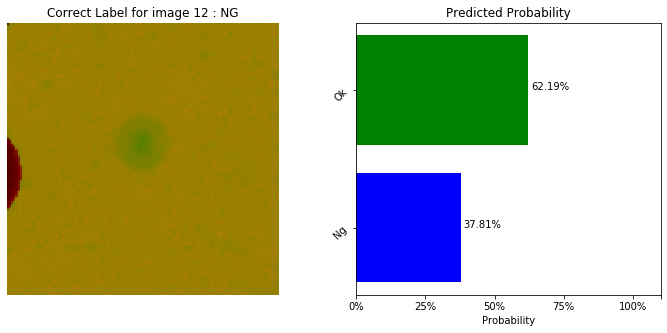

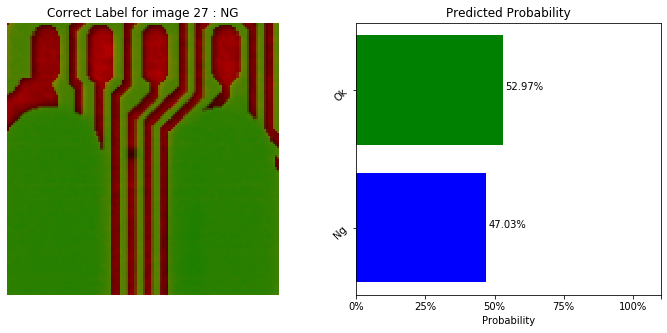

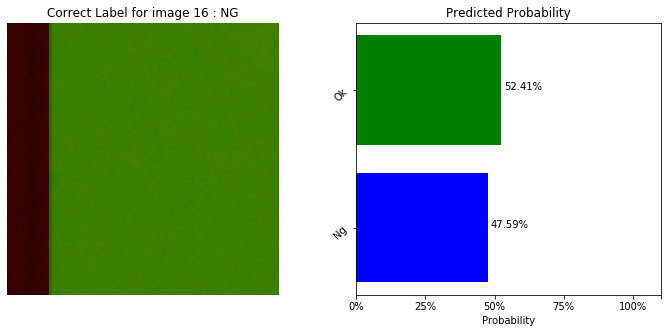

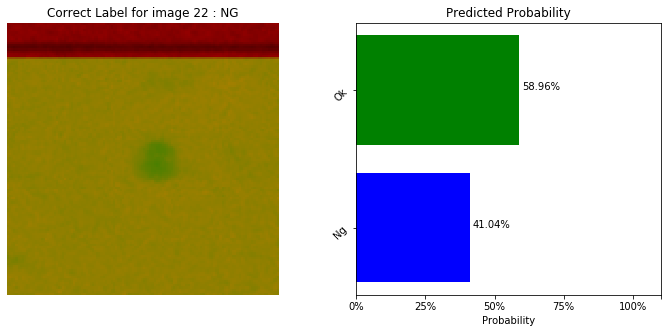

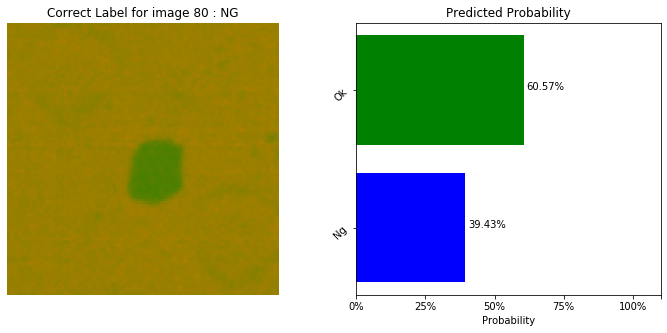

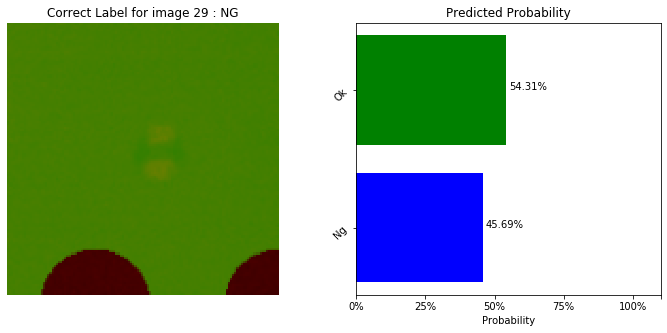

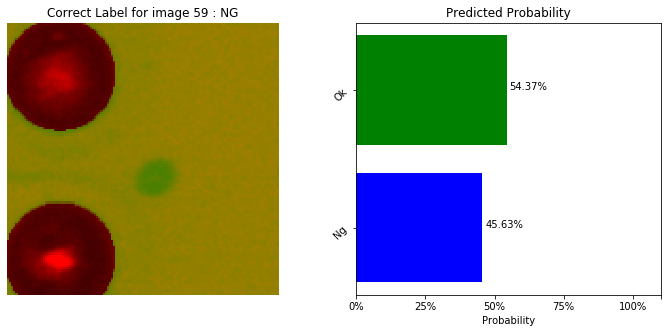

In [21]:
model.plot_evaluate_res(img_type='M', label_class='NG',randomize=True, n_images=10)

NOTE: Cloud Analytic Services dropped table TEMP_PLOT from caslib CASUSER(sasdemo01).


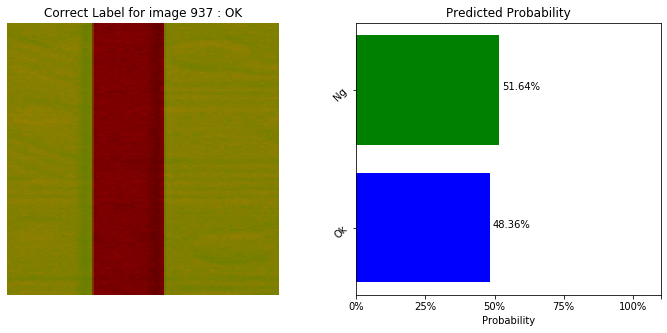

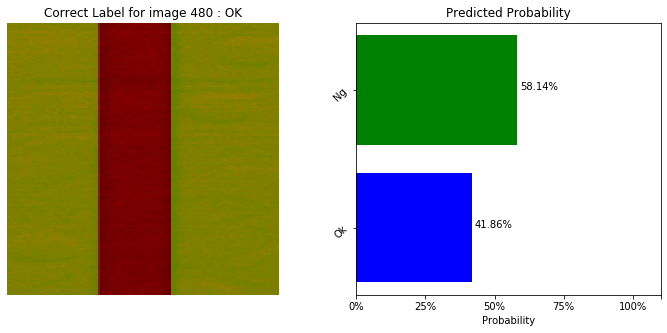

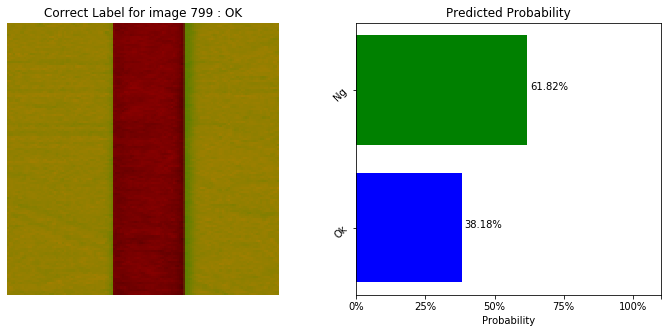

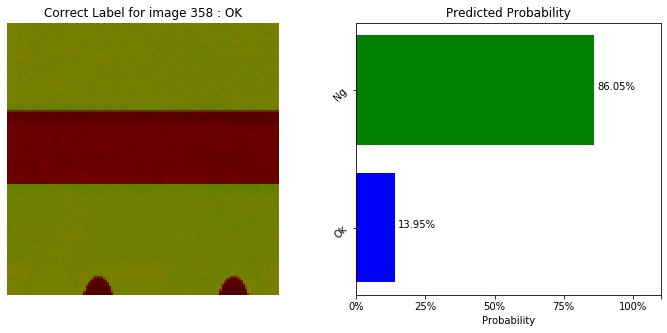

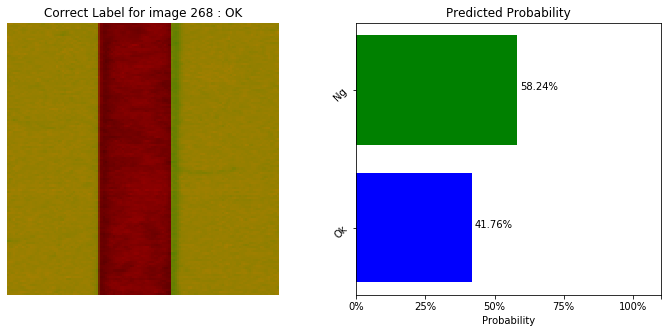

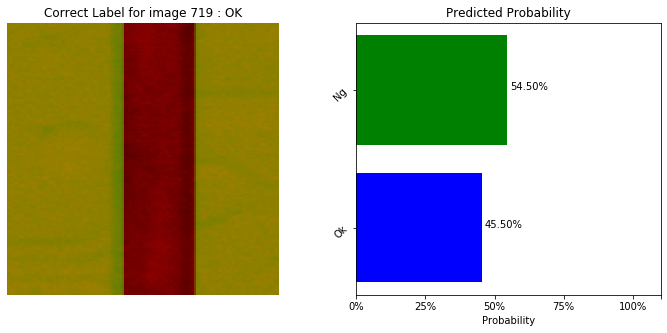

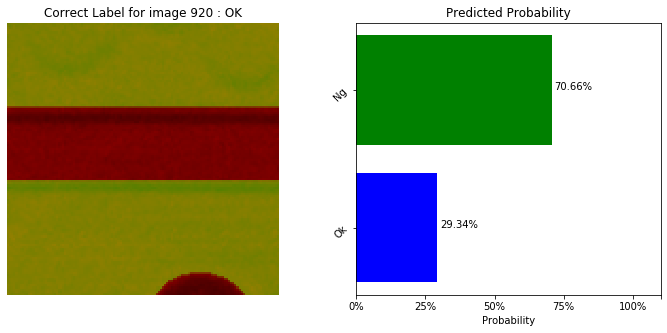

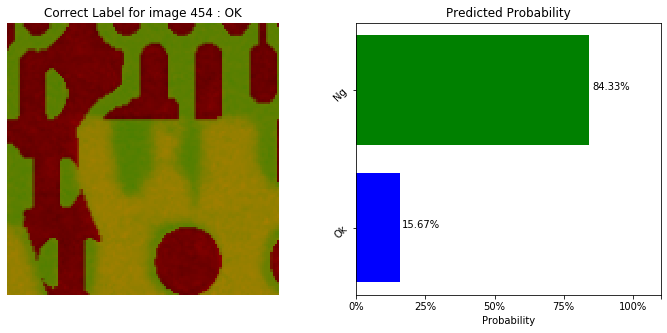

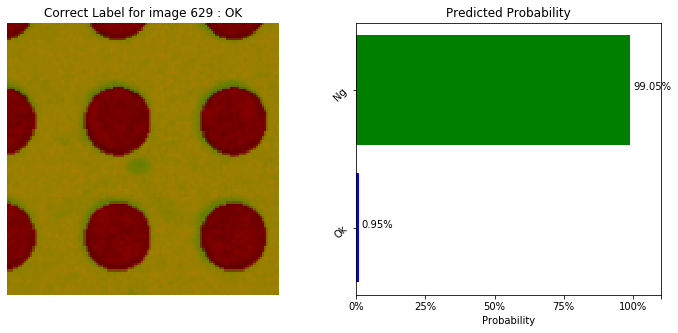

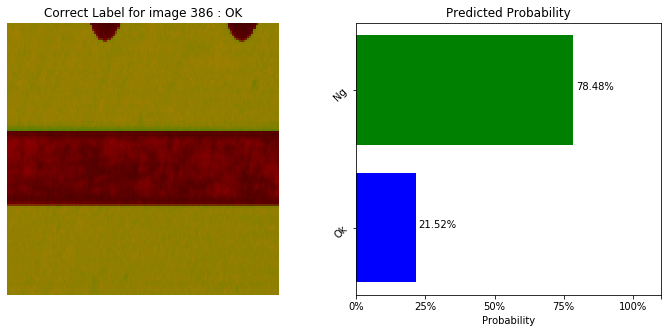

In [22]:
model.plot_evaluate_res(img_type='M', label_class='OK',randomize=True, n_images=10)

In [23]:
ori_cm=pd.crosstab(final_pred.Flag,final_pred.P_label,margins=True)
ori_cm.index =['True_NG','True_OK','All']
ori_cm.columns = ['Predict_NG','Predict_OK','All']
ori_cm

AttributeError: 'DataFrame' object has no attribute 'Flag'

In [162]:
## if want to save all result in one table
#final_pred.to_csv('/home/sasdemo01/re-judge.csv')

In [24]:
final_pred.columns=[""]

,y_star,model_name,image_path,class_reason,y_hat_confidence,class
0,OK,VGG16_SAS,/usr/src/aiinsp/data/S1_Machvision_AVI/S1_2019...,PRED,0.008991,NG
1,OK,VGG16_SAS,/usr/src/aiinsp/data/S1_Machvision_AVI/S1_2019...,PRED,0.024932,NG
2,OK,VGG16_SAS,/usr/src/aiinsp/data/S1_Machvision_AVI/S1_2019...,PRED,0.019276,NG
3,OK,VGG16_SAS,/usr/src/aiinsp/data/S1_Machvision_AVI/S1_2019...,PRED,0.024840,NG
4,OK,VGG16_SAS,/usr/src/aiinsp/data/S1_Machvision_AVI/S1_2019...,PRED,0.425692,NG
...,...,...,...,...,...,...
54247,OK,VGG16_SAS,/usr/src/aiinsp/data/S1_Machvision_AVI/S1_2019...,PRED,0.582770,OK
54248,OK,VGG16_SAS,/usr/src/aiinsp/data/S1_Machvision_AVI/S1_2019...,PRED,0.151938,NG
54249,OK,VGG16_SAS,/usr/src/aiinsp/data/S1_Machvision_AVI/S1_2019...,PRED,0.610827,OK
54250,OK,VGG16_SAS,/usr/src/aiinsp/data/S1_Machvision_AVI/S1_2019...,PRED,0.664854,OK


In [ ]:
#s.endsession()